[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/khetansarvesh/MSML_602/blob/main/Project/checkpoint2.ipynb)

# **Installing and Importing Libraries**

In [68]:
!pip install -U pip
!pip install "cleanvision[huggingface]"
!pip install transformers

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset, concatenate_datasets
from cleanvision import Imagelab
from PIL import Image
import requests
from transformers import CLIPProcessor, CLIPModel
import torch
import cv2
import imagehash

# **Importing Dataset from Hugging Face**

In [70]:
dataset_dict = load_dataset("zalando-datasets/fashion_mnist")
train_images = np.array(dataset_dict['train']['image'])
train_labels = np.array(dataset_dict['train']['label'])

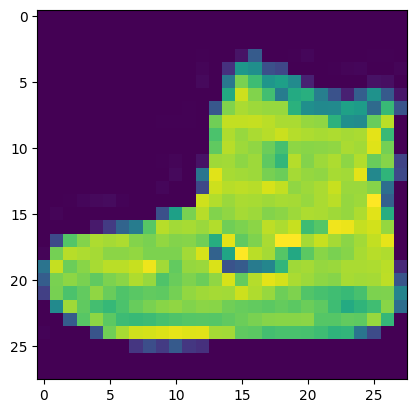

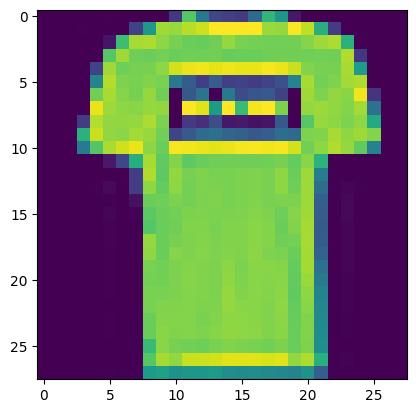

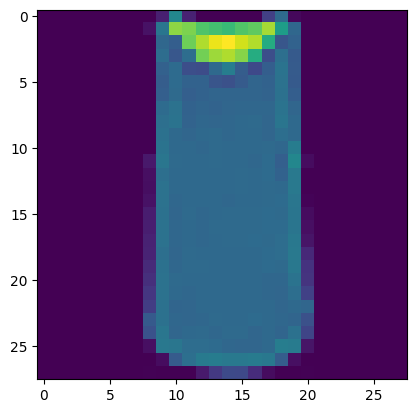

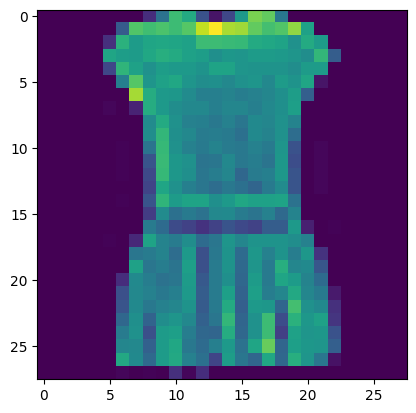

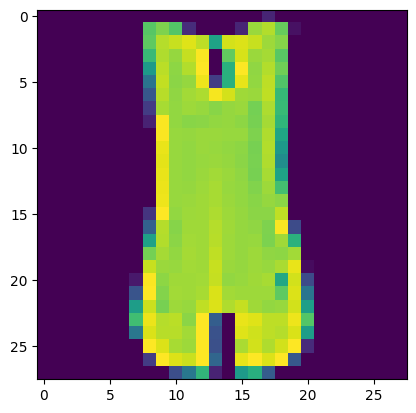

In [71]:
# showing some sample images
for im in range(5):
  plt.imshow(train_images[im])
  plt.show()

# **Data Processing and Cleaning**

Instead of manually creating functions for each type of potential issue in the dataset for example Low Information / Illumination Issue / Blurry Images / ....we will use [IMAGELAB](https://github.com/cleanlab/cleanvision) LIBRARY which does all of this for use at once

In [72]:
imagelab = Imagelab(hf_dataset=dataset_dict['train'], image_key="image")
imagelab.find_issues()

Checking for dark, light, odd_aspect_ratio, low_information, exact_duplicates, near_duplicates, blurry, grayscale, odd_size images ...


  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

Issue checks completed. 70003 issues found in the dataset. To see a detailed report of issues found, use imagelab.report().


In [73]:
imagelab.issue_summary

,issue_type,num_images
0,grayscale,60000
1,low_information,9266
2,near_duplicates,721
3,dark,16
4,light,0
5,odd_aspect_ratio,0
6,blurry,0
7,odd_size,0
8,exact_duplicates,0


In [74]:
# Following dataset helps us to view information about each image, such as what types of issues it exhibits and its quality score with respect to each type of issue.
issue_df = imagelab.issues
issue_df

,odd_size_score,is_odd_size_issue,odd_aspect_ratio_score,is_odd_aspect_ratio_issue,low_information_score,is_low_information_issue,light_score,is_light_issue,grayscale_score,is_grayscale_issue,dark_score,is_dark_issue,blurry_score,is_blurry_issue,exact_duplicates_score,is_exact_duplicates_issue,near_duplicates_score,is_near_duplicates_issue
0,1.0,False,1.0,False,0.471182,False,1.0,False,0,True,0.964706,False,0.782126,False,1.0,False,1.0,False
1,1.0,False,1.0,False,0.488036,False,1.0,False,0,True,0.992824,False,0.609102,False,1.0,False,1.0,False
2,1.0,False,1.0,False,0.307095,False,1.0,False,0,True,0.835373,False,0.759629,False,1.0,False,1.0,False
3,1.0,False,1.0,False,0.412742,False,1.0,False,0,True,0.762118,False,0.793485,False,1.0,False,1.0,False
4,1.0,False,1.0,False,0.326907,False,1.0,False,0,True,1.000000,False,0.830525,False,1.0,False,1.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,1.0,False,1.0,False,0.273430,True,1.0,False,0,True,0.868078,False,0.830474,False,1.0,False,1.0,False
59996,1.0,False,1.0,False,0.277721,True,1.0,False,0,True,0.996078,False,0.867324,False,1.0,False,1.0,False
59997,1.0,False,1.0,False,0.348192,False,1.0,False,0,True,1.000000,False,0.852952,False,1.0,False,1.0,False
59998,1.0,False,1.0,False,0.436144,False,1.0,False,0,True,0.620275,False,0.507929,False,1.0,False,1.0,False


## Check for Images with Low Information in dataset
There are many ways to check if the image contains low information or not eg using entropy value or using variance across different axes of the image.

In [75]:
images_with_low_information = issue_df[issue_df['is_low_information_issue'] == True].reset_index()[['index','low_information_score']]

In [76]:
images_with_low_information

,index,low_information_score
0,8,0.292135
1,13,0.296907
2,14,0.244999
3,30,0.169186
4,38,0.294015
...,...,...
9261,59951,0.268701
9262,59991,0.267101
9263,59995,0.273430
9264,59996,0.277721


0.0899287558436393


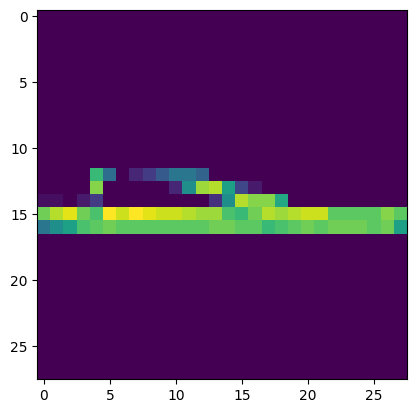

0.11854532484067504


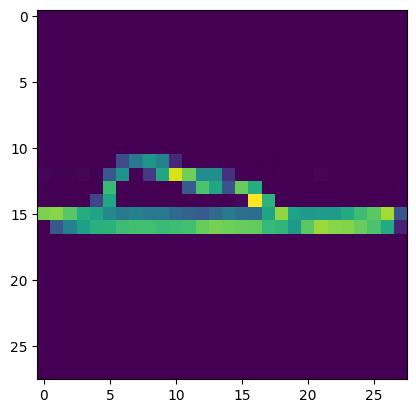

0.11101413243105429


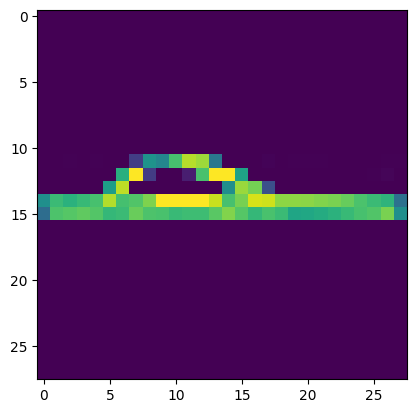

0.1163893504731558


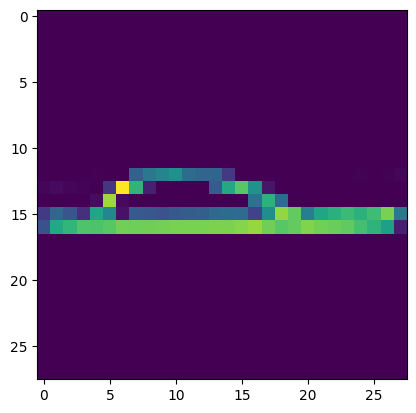

0.10934567159828923


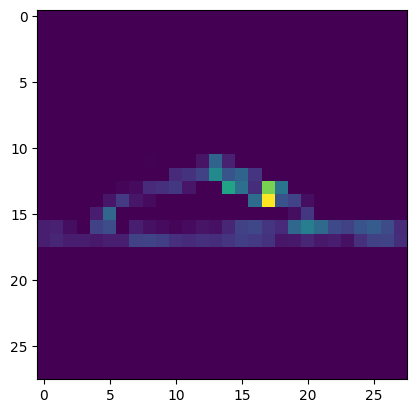

0.11897443116276374


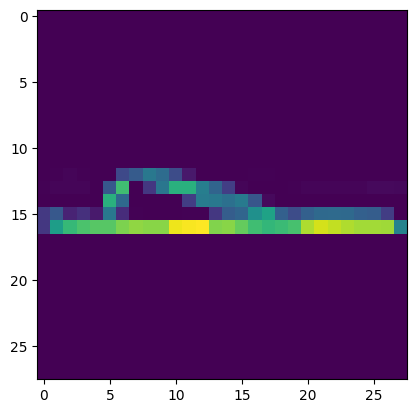

0.10875941991646615


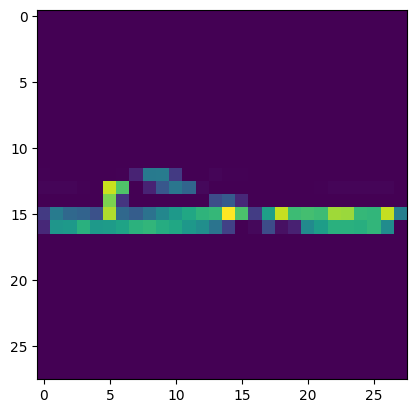

0.11192521316499089


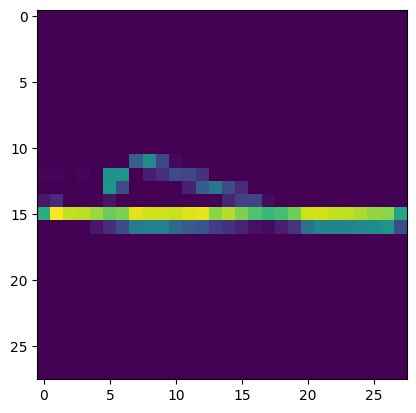

0.11186004243688963


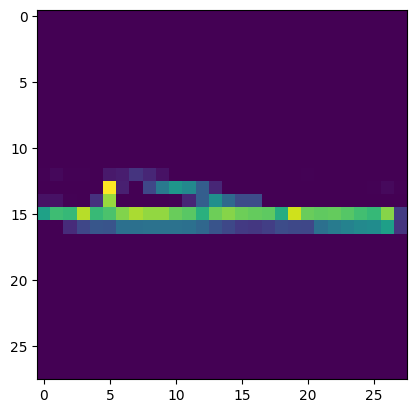

0.1164707011683056


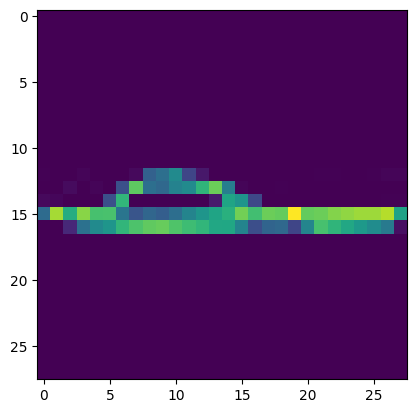

0.11040733886270906


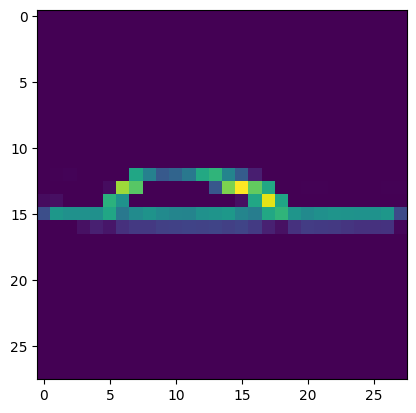

0.11625270131375705


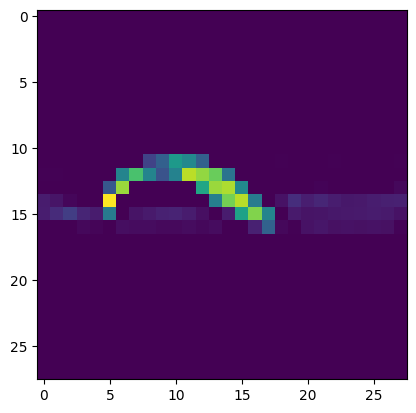

0.11109588249451337


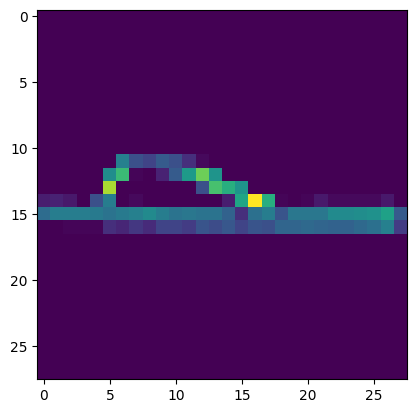

0.11771250277269284


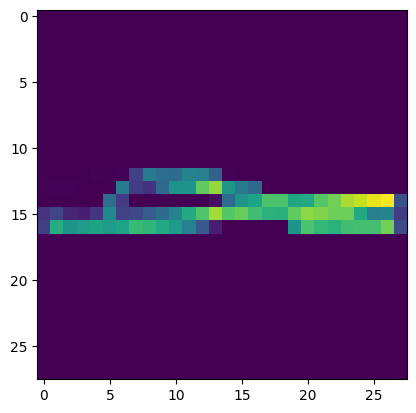

0.09260060769381392


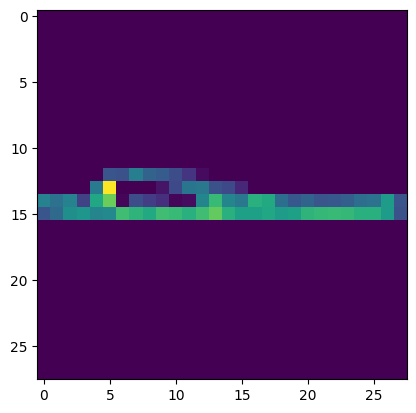

0.11698095462301046


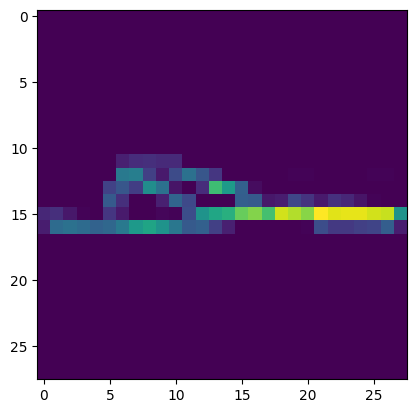

0.0679754028789433


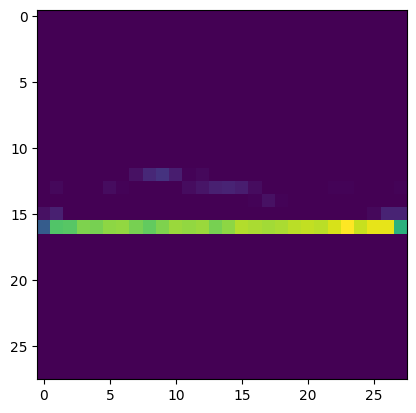

0.10871081749139307


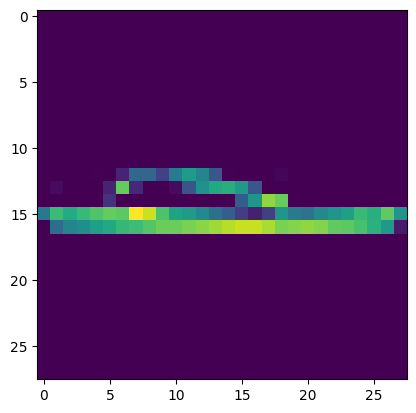

0.11589830084100633


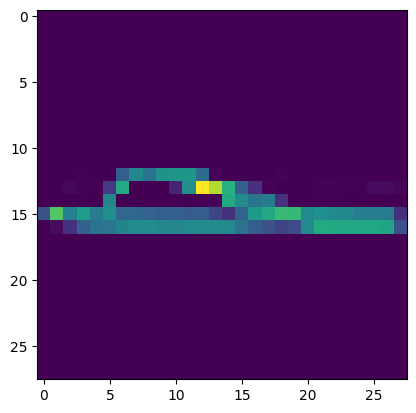

0.1178638505264932


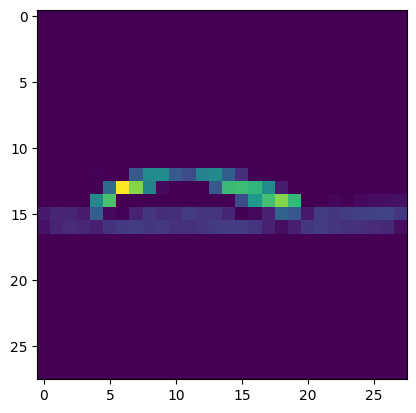

0.11850405429912536


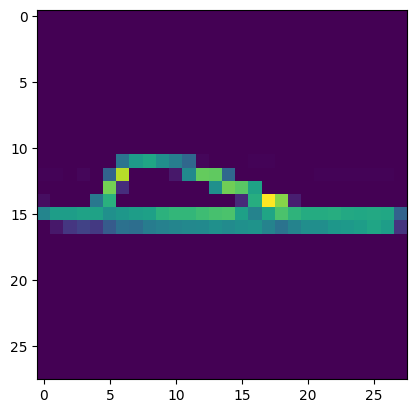

0.11990548566545312


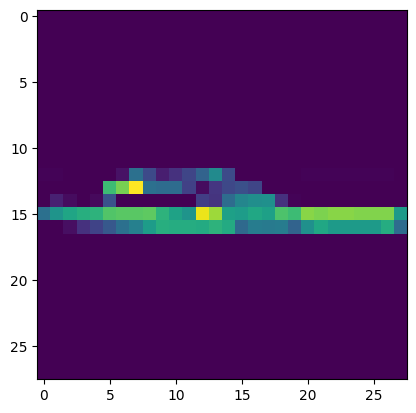

0.10774408797585569


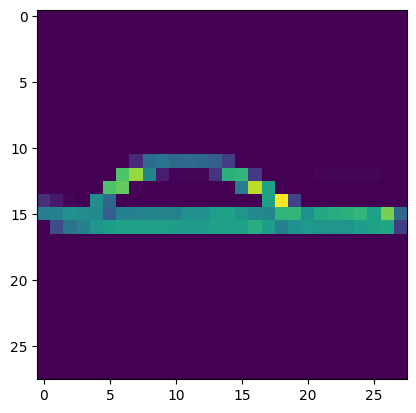

0.11306463117649751


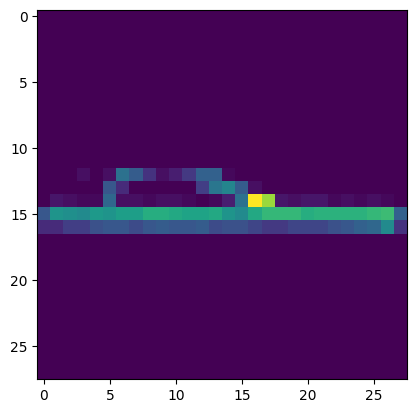

0.11354947005140958


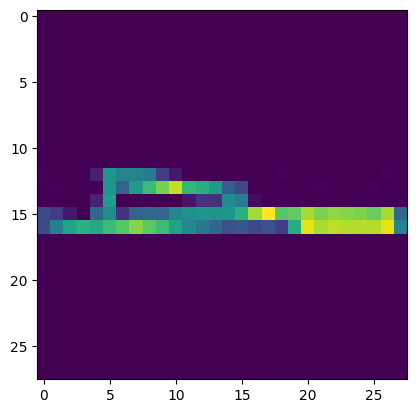

0.11170031143844045


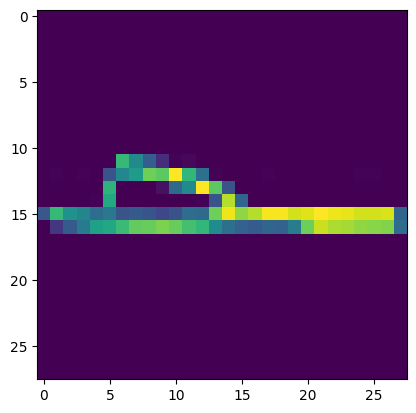

0.11739680256685286


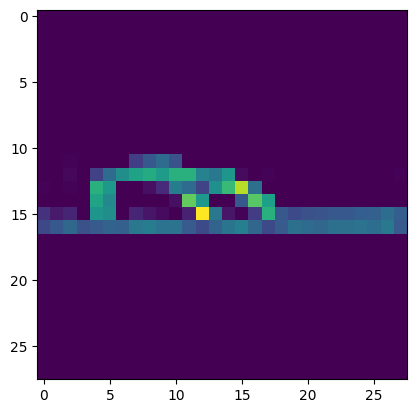

0.10851604198761683


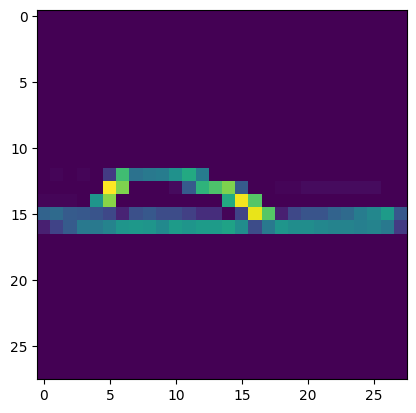

0.10961169433042


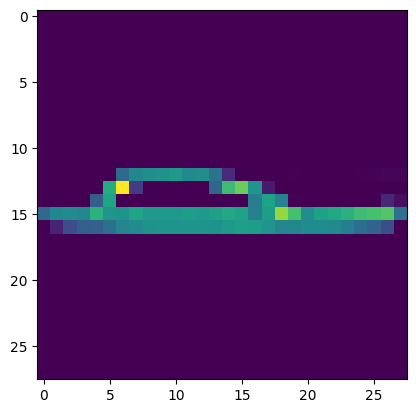

0.1155371859471197


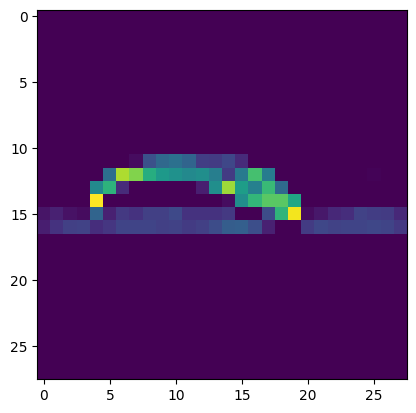

In [77]:
# seeing some sample images with low information
for score, i in zip(images_with_low_information['low_information_score'], images_with_low_information['index']):
  if score < 0.12:
    plt.imshow(train_images[i])
    print(score)
    plt.show()

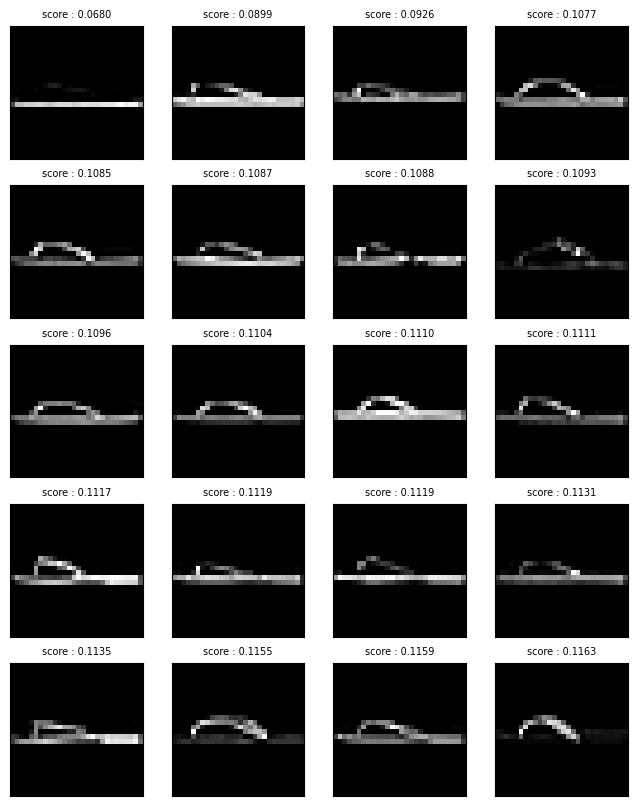

In [78]:
imagelab.visualize(issue_types=["low_information"], num_images=20)

In [79]:
img_index_with_low_information = images_with_low_information['index']

In [80]:
'''
Following is a way to manually calculate entropy value of an image to check for low information issue.
This method suggests that there are no images with low information in our dataset.
I am not sure what method does the Imagelab library use to check for low information issue.
'''

# def calculate_entropy(image):
#     histogram = cv2.calcHist([image], [0], None, [256], [0, 256])
#     histogram = histogram / np.sum(histogram)
#     entropy = -np.sum(histogram * np.log2(histogram + np.finfo(float).eps))
#     return entropy

# entropies = [calculate_entropy(image) for image in train_images]
# threshold = 0.5  # Adjust this threshold as needed
# low_entropy_images = [image for image, entropy in zip(train_images, entropies) if entropy < threshold]

# for image in low_entropy_images:
#     plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
#     plt.show()

'\nFollowing is a way to manually calculate entropy value of an image to check for low information issue.\nThis method suggests that there are no images with low information in our dataset.\nI am not sure what method does the Imagelab library use to check for low information issue.\n'

## Check for Blurry Images in dataset
There are many ways to check blurriness in an image like laplacian and fourier transform.

Imagelab library suggests that are are no blurry images in our dataset, let's check that manually too by implementing our own version to check for blurry images.

In [81]:
is_blurry_image = [cv2.Laplacian(image, cv2.CV_64F).var()<1000 for image in train_images]

In [82]:
for i in is_blurry_image:
  if i == True:
    print(i)

Hence this shows that there are no blurry images in our dataset

## Check for Light / Dark Images in dataset
Here we first identify if there are too dark or too light images in our dataset


In [83]:
dark_images = issue_df[issue_df['is_dark_issue'] == True].reset_index()[['index','dark_score']]

In [84]:
dark_images

,index,dark_score
0,1820,0.307216
1,2195,0.217686
2,7865,0.307882
3,11870,0.213098
4,13690,0.309961
5,16835,0.269333
6,17738,0.313216
7,18047,0.308549
8,24370,0.230118
9,27292,0.270588


0.3072156862745095


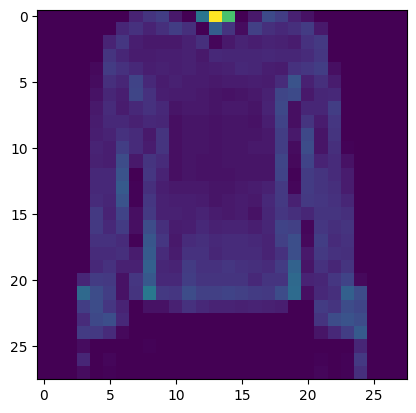

0.21768627450980343


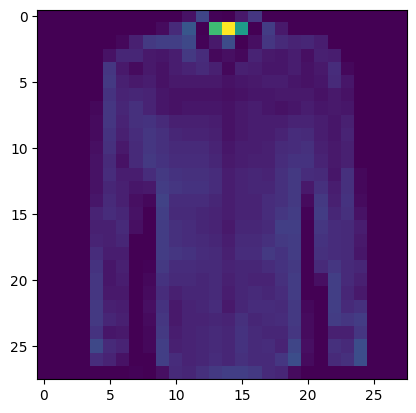

0.307882352941176


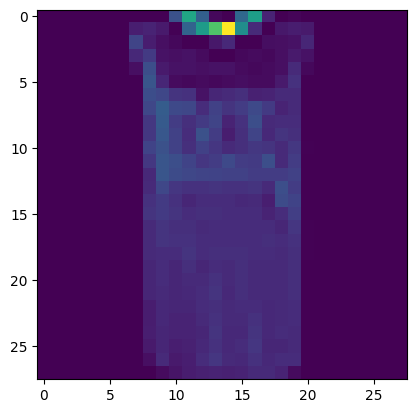

0.21309803921568596


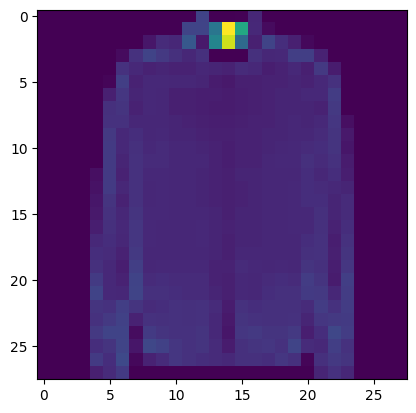

0.30996078431372354


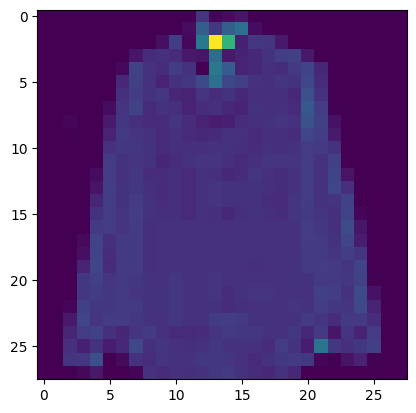

0.2693333333333327


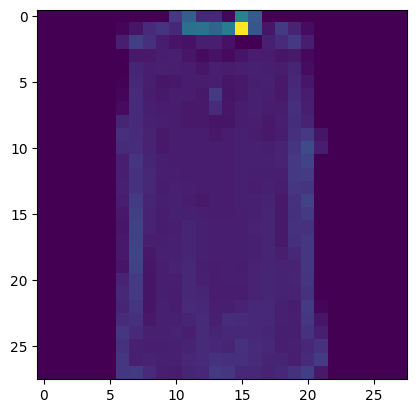

0.3132156862745081


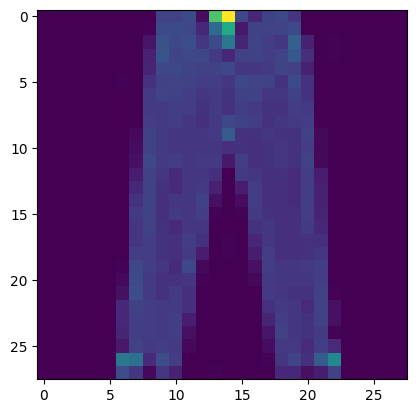

0.30854901960784253


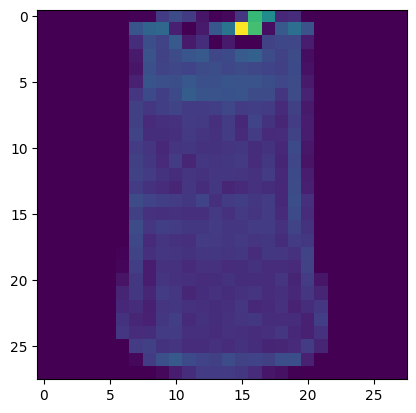

0.23011764705882287


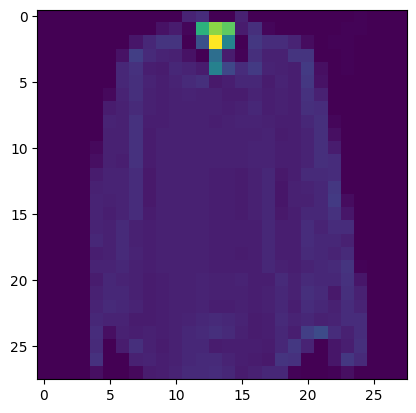

0.27058823529411763


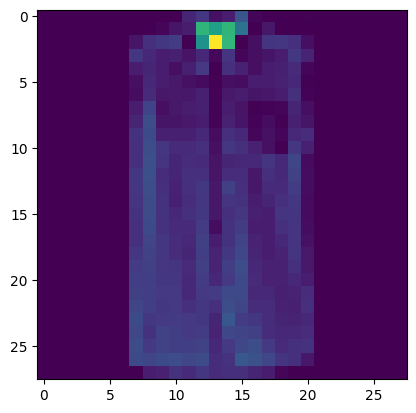

0.2045882352941175


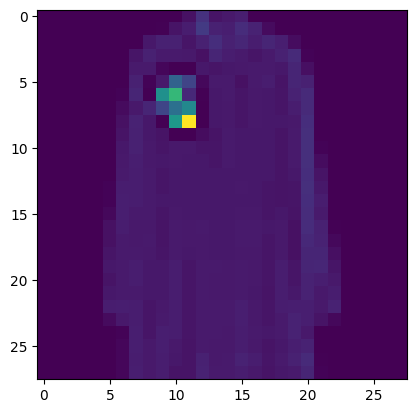

0.30596078431372453


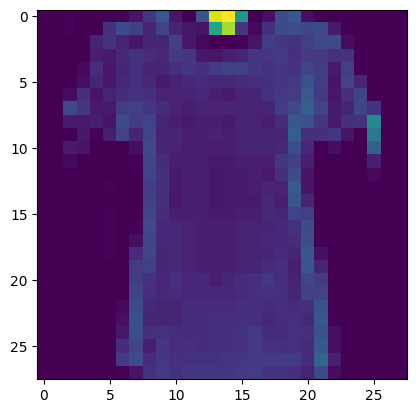

0.2896078431372541


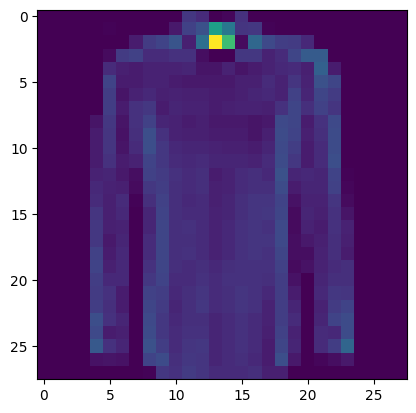

0.20392156862745098


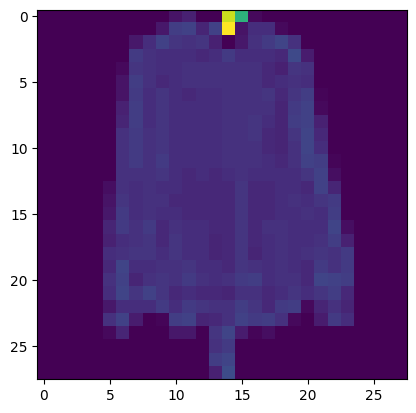

0.25623529411764673


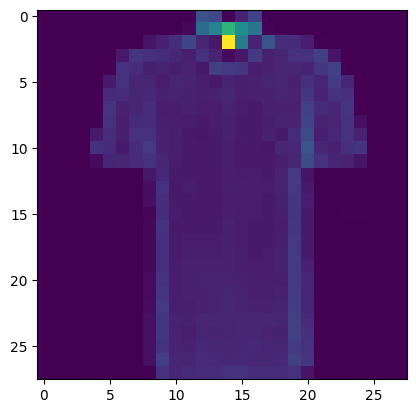

0.2836862745098036


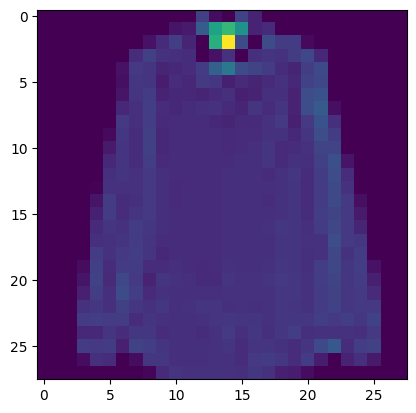

In [85]:
# seeing some sample images with low information
for score, i in zip(dark_images['dark_score'], dark_images['index']):
  plt.imshow(train_images[i])
  print(score)
  plt.show()

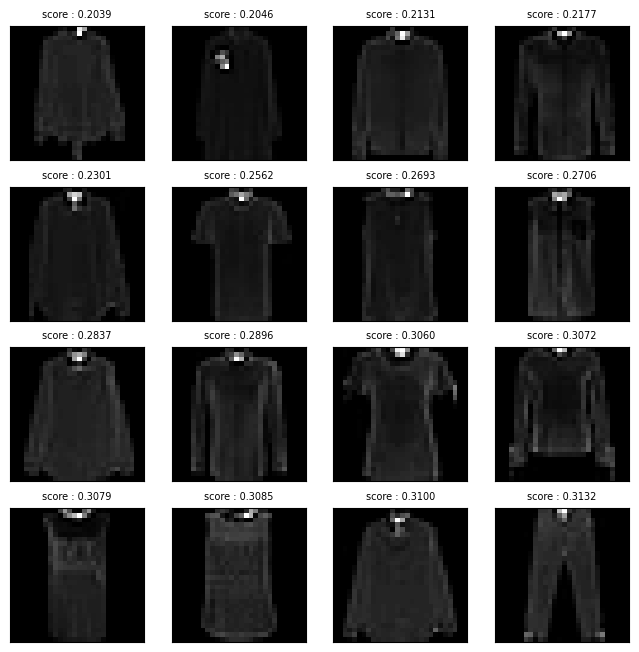

In [86]:
imagelab.visualize(issue_types=["dark"], num_images=20)

In [87]:
dark_img_index = dark_images['index']

## Check for duplicate Images
To manually implement this you will have to convert the images into embeddings and then using a similarity measure you can check if the images are similiar or not. If the similarity is too high means they are near duplicates. We will implement this method later from scratch but now we will see dupilcate images identified by imagelab library

In [88]:
duplicate_images = issue_df[issue_df['is_near_duplicates_issue'] == True].reset_index()[['index','near_duplicates_score']]

In [89]:
duplicate_images

,index,near_duplicates_score
0,189,0.500000
1,264,0.500000
2,337,0.333333
3,360,0.500000
4,562,0.500000
...,...,...
716,59456,0.500000
717,59653,0.500000
718,59690,0.333333
719,59812,0.500000


Set: 0


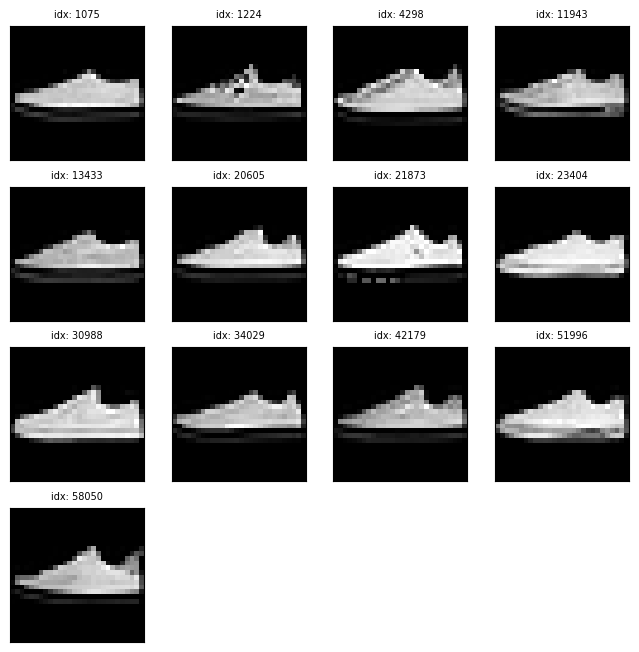

Set: 1


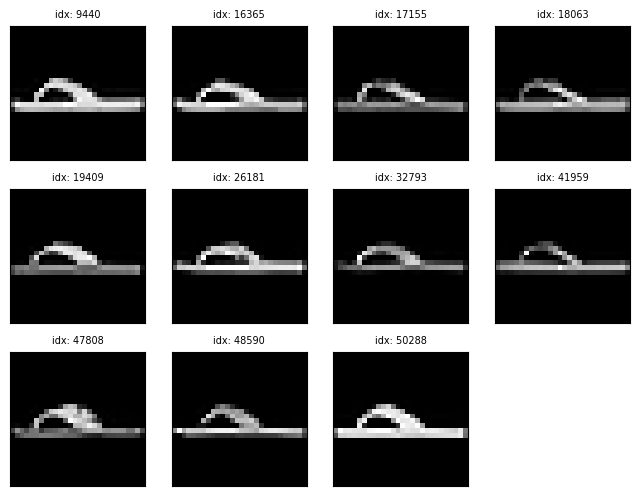

Set: 2


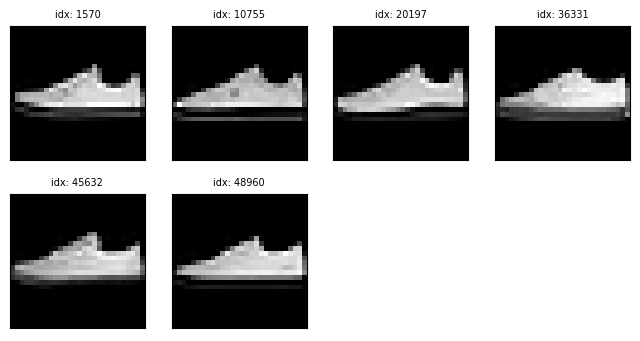

Set: 3


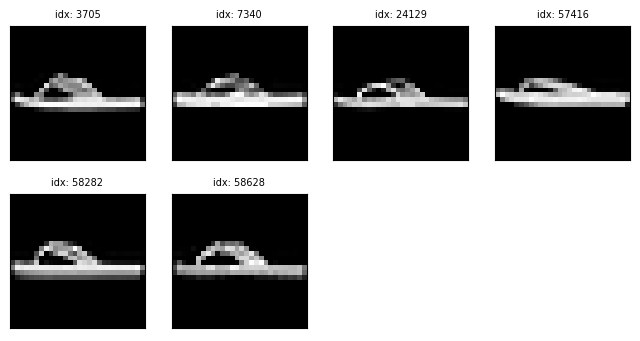

Set: 4


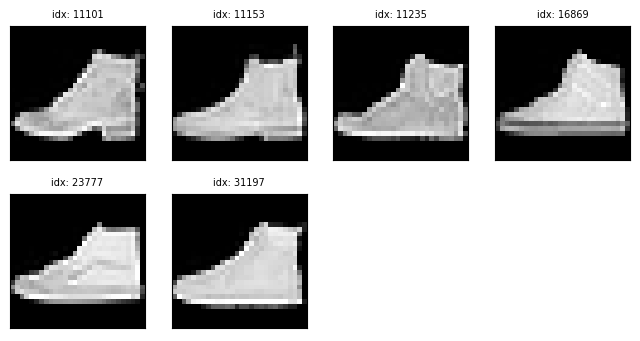

In [90]:
# visualizing 5 near duplicate sets
imagelab.visualize(issue_types=["near_duplicates"], num_images=5)

In [91]:
print(f'Total #Duplicate Sets Found : {len(imagelab.info["near_duplicates"]["sets"])}')

Total #Duplicate Sets Found : 314


In [92]:
duplicate_images_index = []
for i in imagelab.info["near_duplicates"]["sets"]:
  for j,counter in zip(i,range(0,len(i))):
    if counter == 0:
      continue
    else:
      duplicate_images_index.append(j)

## Removing Issue Based Images from the Dataset

In [113]:
img_index_to_remove = list(set(list(img_index_with_low_information) + list(dark_img_index) + list(duplicate_images_index)))

In [117]:
reduced_train_images = []
reduced_train_labels = []

In [118]:
for counter, im, label in zip(range(len(train_images)), train_images, train_labels):
  if counter in img_index_to_remove:
    continue
  else:
    reduced_train_images.append(im)
    reduced_train_labels.append(label)

# **Image Resizing / Transformations**
Here we check if all the images are of same shape and size, else we perform some transformations / reshaping

In [121]:
size_list = [reduced_train_images[i].shape for i in range(len(reduced_train_images))]
print(set(size_list))

{(28, 28)}


Hence this shows that all the images in our dataset are of size 28*28 hence we dont need to do any reshaping

# **Normalize Data**
Here we normalize our pixel values in dataset from 0-255 to 0-1


In [123]:
reduced_train_images[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,
          0,   0,  13,  73,   0,   0,   1,   4,   0,   0,   0,   0,   1,
          1,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
          0,  36, 136, 127,  62,  54,   0,   0,   0,   1,   3,   4,   0,
          0,   3],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   6,
          0, 102, 204, 176, 134, 144, 123,  23,   0,   0,   0,   0,  12,
         10,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0, 155, 236, 207, 178, 107, 156, 161, 109,  64,  23,  77, 130,
         72,  15],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   0,
         69, 207, 223, 218, 216, 216, 163, 127, 121, 122, 146, 141,  88,
        172,  66],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   1,   1,   0,
        200, 232, 232, 233, 229, 223, 223, 215, 213, 164, 127, 123, 196,
        229,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
        183, 225, 216, 223, 228, 235, 227, 224, 222, 224, 221, 223, 245,
        173,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
        193, 228, 218, 213, 198, 180, 212, 210, 211, 213, 223, 220, 243,
        202,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   3,   0,  12,
        219, 220, 212, 218, 192, 169, 227, 208, 218, 224, 212, 226, 197,
        209,  52],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   6,   0,  99,
        244, 222, 220, 218, 203, 198, 221, 215, 213, 222, 220, 245, 119,
        167,  56],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   4,   0,   0,  55,
        236, 228, 230, 228, 240, 232, 213, 218, 223, 234, 217, 217, 209,
         92,   0],
       [  0,   0,   1,   4,   6,   7,   2,   0,   0,   0,   0,   0, 237,
        226, 217, 223, 222, 219, 222, 221, 216, 223, 229, 215, 218, 255,
         77,   0],
       [  0,   3,   0,   0,   0,   0,   0,   0,   0,  62, 145, 204, 228,
        207, 213, 221, 218, 208, 211, 218, 224, 223, 219, 215, 224, 244,
        159,   0],
       [  0,   0,   0,   0,  18,  44,  82, 107, 189, 228, 220, 222, 217,
        226, 200, 205, 211, 230, 224, 234, 176, 188, 250, 248, 233, 238,
        215,   0],
       [  0,  57, 187, 208, 224, 221, 224, 208, 204, 214, 208, 209, 200,
        159, 245, 193, 206, 223, 255, 255, 221, 234, 221, 211, 220, 232,
        246,   0],
       [  3, 202, 228, 224, 221, 211, 211, 214, 205, 205, 205, 220, 240,
         80, 150, 255, 229, 221, 188, 154, 191, 210, 204, 209, 222, 228,
        225,   0],
       [ 98, 233, 198, 210, 222, 229, 229, 234, 249, 220, 194, 215, 217,
        241,  65,  73, 106, 117, 168, 219, 221, 215, 217, 223, 223, 224,
        229,  29],
       [ 75, 204, 212, 204, 193, 205, 211, 225, 216, 185, 197, 206, 198,
        213, 240, 195, 227, 245, 239, 223, 218, 212, 209, 222, 220, 221,
        230,  67],
       [ 48, 203, 183, 194, 213, 197, 185, 190, 194, 192, 202, 214, 219,
        221, 220, 236, 225, 216, 199, 206, 186, 181, 177, 172, 181, 205,
        206, 115],
       [  0, 122, 219, 193, 179, 171, 183, 196, 204, 210, 213, 207, 211,
        210, 200, 196, 194, 191, 195, 191, 198, 192, 176, 156, 167, 177,
        210,  92],
       [  0,   0,  74, 189, 212, 191, 175, 172, 175, 181, 185, 188, 189,
        188, 193, 198, 204, 209, 210, 210, 211, 188, 188, 194, 192, 216,
        170,   0],
       [  2,   0,   0,   0,  66, 200, 22

In [126]:
def normalize_image_np(image):
    norm_img = (image - np.min(image)) / (np.max(image) - np.min(image))
    return norm_img

In [127]:
normalized_train_images = [normalize_image_np(image) for image in reduced_train_images]

In [129]:
normalized_train_images[0]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.    

# **Create Embeddings using CLIP Model**

In [132]:
from transformers import AutoImageProcessor, AutoModel
model_ckpt = "nateraw/vit-base-beans"
# model_ckpt = "openai/clip-vit-base-patch32
processor = AutoImageProcessor.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)

SyntaxError: unterminated string literal (detected at line 3) (<ipython-input-132-89c2e276e421>, line 3)

In [ ]:
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

inputs = processor(text=["a photo of a cat", "a photo of a dog"], images=image, return_tensors="pt", padding=True)

outputs = model(**inputs)
logits_per_image = outputs.logits_per_image # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities


In [ ]:
inputs = processor(images=train_images, return_tensors="pt")

with torch.no_grad():
    image_features = model.get_image_features(**inputs)

image_embeddings_np = image_features.cpu().numpy()

ValueError: Unable to infer channel dimension format

# **Data Exploration**

## Remove Near Duplicate Images

## Outlier Handling

In [ ]:
# mat a plot using PCA to convert to 2d and shot the plot of outliers